In [91]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import pickle
from sklearn. metrics import classification_report, roc_auc_score, roc_curve

In [92]:
df = pd.read_csv("comments_final2.csv", encoding="utf-8", index_col=0)

In [93]:
df.shape

(36932, 3)

In [94]:
df.head()

,processed_text,class,word_count
Column1,,,
601,sách không_đối thần,neutral,3
3070,tuyệt_đối lượm lỗi,negative,3
3370,chữ đọc dịch,negative,3
3784,quá_thất vọng hàng,negative,3
3881,bì bị_nhăn góc,neutral,3


### Duplicate Data

In [95]:
# Display duplicate rows
print('Duplicate data:', df.duplicated().sum())
df[df.duplicated()]

Duplicate data: 1334


,processed_text,class,word_count
Column1,,,
17095,chờ tuần sách,negative,3
23289,sản_phẩm rất_tệ tưởng,negative,3
27948,bọc sách hỏng,negative,3
28462,truyện rách bìa,negative,3
33421,không_bookcare không_đóng gói,negative,3
...,...,...,...
20925,mặt đóng_gói hàng dịch chấp_nhận đóng_gói sơ_s...,positive,91
29701,mặt đóng_gói hàng dịch chấp_nhận đóng_gói sơ_s...,positive,91
51199,đóng gói hàng ẩu_tả sách bị_móp góc kiểm chất_...,negative,99


In [96]:
# Drop all duplicate rows
df.drop_duplicates(inplace=True)
print('Duplicate data:', df.duplicated().sum())
print(df.shape)
# Reset index
df.reset_index(drop=True, inplace=True)

Duplicate data: 0
(35598, 3)


In [97]:
df['class'].value_counts()

positive    26615
negative     5058
neutral      3925
Name: class, dtype: int64

### TF-IDF Vectorizer

In [98]:
# Create a TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=0.02)

In [99]:
# Fit the TfidfVectorizer object to the data
x = tfidf_vectorizer.fit(df['processed_text'].values.astype('U'))

In [100]:
# Transform the data
X = tfidf_vectorizer.transform(df['processed_text'].values.astype('U'))

In [101]:
### BUG: 
# This is probably because you are using an older scikit-learn version than the one this code was written for.
# get_feature_names_out is a method of the class sklearn.feature_extraction.text.TfidfVectorizer since scikit-learn 1.0. Previously, there was a similar method called get_feature_names.
# So you should update your scikit-learn package, or use the old method (not recommended).
# Create a new dataframe with the transformed data
df_new = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [102]:
df_new.head()

,bàn,bé,bìa,bìa sách,bẩn,bọc,chất_lượng,chất_lượng sách,chống,chống sốc,...,đóng gói,đóng_gói,đóng_gói cẩn_thận,đơn,đầu,đẹp,đọc,đọc sách,đổi,ổn
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.325422,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [103]:
y = df['class']

In [104]:
print(X.shape, y.shape)

(35598, 107) (35598,)


### Cross Validation

In [105]:
# Choose 0.3, 0.2 as the test size
test_size_list = [.3, .2]
# Run 5 times for each test_size
for test_size in test_size_list:
  print('Test size: ', test_size)
  accuracy_train_list = []
  accuracy_test_list = []
  for i in range(5):
    print('Run: ', i)
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    # Create a LogisticReg (for faster training)
    clf = LogisticRegression()
    # Train the classifier
    clf.fit(X_train, y_train)
    # Make predictions
    y_pred = clf.predict(X_test)
    # Calculate the accuracy
    accuracy_train = accuracy_score(y_train, clf.predict(X_train))
    accuracy_test = accuracy_score(y_test, y_pred)
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)
  print('Test size: ', test_size, ' Train accuracy: ', sum(accuracy_train_list) / len(accuracy_train_list), ' Test accuracy: ',
      sum(accuracy_test_list) / len(accuracy_test_list))
  print('--------------------------------------------------')

Test size:  0.3
Run:  0
Run:  1
Run:  2
Run:  3


c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Run:  4
Test size:  0.3  Train accuracy:  0.7764427321614897  Test accuracy:  0.7744756554307116
--------------------------------------------------
Test size:  0.2
Run:  0
Run:  1


c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Run:  2
Run:  3


c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Run:  4
Test size:  0.2  Train accuracy:  0.7756232881522579  Test accuracy:  0.7765730337078651
--------------------------------------------------


c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [106]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Model Comparision

In [107]:
models = [
    RandomForestClassifier(n_estimators=50),
    RandomForestClassifier(n_estimators=100),
    KNeighborsClassifier(n_neighbors=3),
    KNeighborsClassifier(n_neighbors=5),
    KNeighborsClassifier(n_neighbors=7),
    LogisticRegression(multi_class='multinomial'),
    SVC(kernel='sigmoid'),
    MultinomialNB(),
]

In [108]:
def get_model_name(model):
  model_name = model.__class__.__name__
  if model_name == 'KNeighborsClassifier':
    model_name = model_name + '_' + str(model.n_neighbors)
  elif model_name == 'RandomForestClassifier':
    model_name = model_name + '_' + str(model.n_estimators)
    
  return model_name

In [109]:
# Number of folds for cross validation
num_folds = 5
# A dataframe to store the results
results = pd.DataFrame(columns=['Model', 'Accuracy Mean', 'Accuracy 3 * STD', 'Time'])
# Integrate through models
for model in models:
  # Get model name
  model_name = get_model_name(model)  
  print('Model: ', model_name, 'running...')
  # Get the current time
  start_time = datetime.now()  
  # Perform cross validation
  cv_results = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='accuracy', n_jobs=-1)  
  # Get the training time
  train_time = datetime.now() - start_time  
  # Get the mean and std of the results
  mean_cv_results = cv_results.mean()
  std_cv_results = cv_results.std()  
  # Store the results
  results = results.append({'Model': model_name,
                            'Accuracy Mean': mean_cv_results,
                            'Accuracy 3 * STD': 3 * std_cv_results,
                            'Time': train_time
                            }, ignore_index=True)

Model:  RandomForestClassifier_50 running...


C:\Users\tinhdaubuoi\AppData\Local\Temp\ipykernel_30652\3118795572.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,


Model:  RandomForestClassifier_100 running...


C:\Users\tinhdaubuoi\AppData\Local\Temp\ipykernel_30652\3118795572.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,


Model:  KNeighborsClassifier_3 running...


C:\Users\tinhdaubuoi\AppData\Local\Temp\ipykernel_30652\3118795572.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,


Model:  KNeighborsClassifier_5 running...


C:\Users\tinhdaubuoi\AppData\Local\Temp\ipykernel_30652\3118795572.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,


Model:  KNeighborsClassifier_7 running...


C:\Users\tinhdaubuoi\AppData\Local\Temp\ipykernel_30652\3118795572.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,


Model:  LogisticRegression running...


C:\Users\tinhdaubuoi\AppData\Local\Temp\ipykernel_30652\3118795572.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,


Model:  SVC running...


C:\Users\tinhdaubuoi\AppData\Local\Temp\ipykernel_30652\3118795572.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,


Model:  MultinomialNB running...


C:\Users\tinhdaubuoi\AppData\Local\Temp\ipykernel_30652\3118795572.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,


### Metric result

In [110]:
# Sort the dataframe by Accuracy Mean in descending order
results = results.sort_values(by='Accuracy Mean', ascending=False).reset_index(drop=True)
results

,Model,Accuracy Mean,Accuracy 3 * STD,Time
0,LogisticRegression,0.772534,0.008332,0 days 00:00:00.701078
1,RandomForestClassifier_100,0.768561,0.007829,0 days 00:00:22.964205
2,RandomForestClassifier_50,0.767197,0.007273,0 days 00:00:16.666974
3,MultinomialNB,0.765350,0.002913,0 days 00:00:00.259208
4,KNeighborsClassifier_7,0.734570,0.013840,0 days 00:00:06.146669
5,SVC,0.726222,0.010050,0 days 00:00:34.016580
6,KNeighborsClassifier_5,0.721687,0.017547,0 days 00:00:06.918908
7,KNeighborsClassifier_3,0.706036,0.020010,0 days 00:00:07.733388


Text(0.5, 1.0, 'Model Comparison')

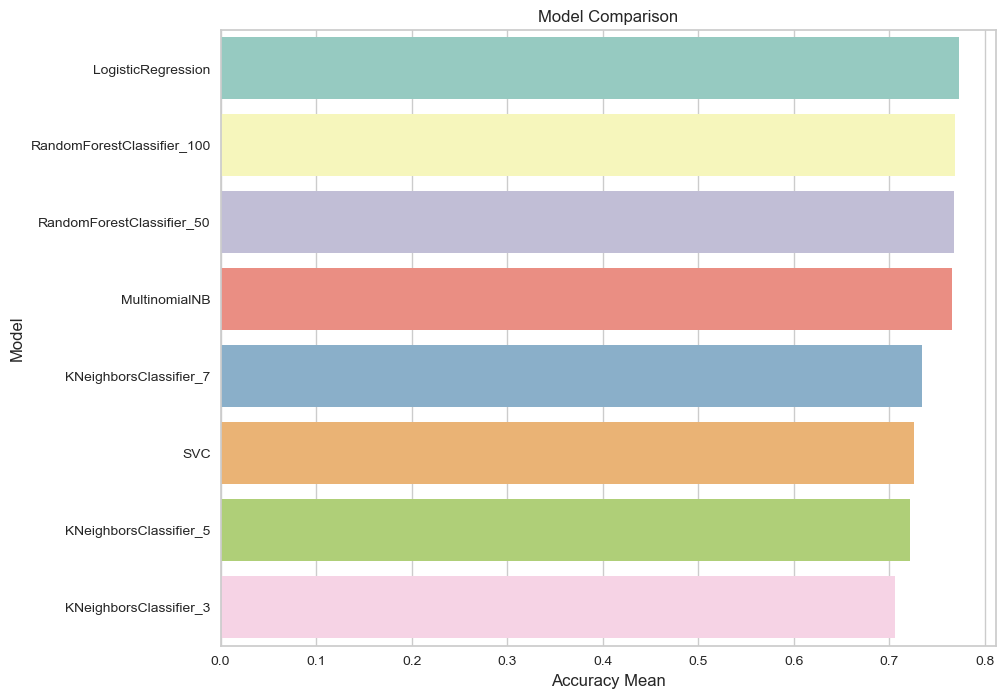

In [111]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Accuracy Mean', y='Model', data=results, palette='Set3')
plt.title('Model Comparison')

###
- Như vậy, ta có thể sơ bộ thấy mô hình logistic Reg cho kết quả tốt hơn các mô hình còn lại

### Classification Report

### 
- Đối với bài toán phân loại này, chúng ta cần quan tâm tới high Recall rating not_like.
- với high Recall cao, thì các True rating not-like phải cao, còn các False-not_like dự báo có thể cao hoặc thấp. 

### 
- Như vậy ta chon Logistic Regression cho việc tinh chỉnh mô hình tối ưu

### Logistic Regression

#### Hyperparameter tuning

In [112]:
# Use GridSearchCV to find the best parameters for the models
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# Create a list of parameters of Logistic Regression for the GridSearchCV
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
#param_grid = {
    #'n_estimators': [100,300, 500, 1000],
    #'learning_rate':[0.001,0.01,0.1, 1]
#}
# Create a list of models to test
clf_grid = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1,cv=5, scoring='accuracy', error_score=0)
search_clf = clf_grid.fit(X_train, y_train)
best_clf = search_clf.best_estimator_

##Score
#cross_clf = cross_val_score(best_clf, X_test, y_test, scoring='accuracy', cv=5, n_jobs=-1)

c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [113]:
print('Best params:', search_clf.best_params_)

Best params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


### Best Params

In [114]:
## Create the best model
best_model = LogisticRegression(C= 10,penalty='l2',solver= 'lbfgs')
# Fit the best model to the training data
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Metrics to Report

In [115]:
# Get the accuracy score for the best model
accuracy_train = round(best_model.score(X_train, y_train) * 100, 3)
accuracy_test = round(best_model.score(X_test, y_test) * 100, 3)
print('Accuracy score for the best model on the training data: ', accuracy_train)
print('Accuracy score for the best model on the test data: ', accuracy_test)

Accuracy score for the best model on the training data:  77.35
Accuracy score for the best model on the test data:  77.893


              precision    recall  f1-score   support

    negative       0.55      0.35      0.43      1503
     neutral       0.27      0.01      0.02      1157
    positive       0.80      0.97      0.88      8020

    accuracy                           0.78     10680
   macro avg       0.54      0.44      0.44     10680
weighted avg       0.71      0.78      0.72     10680



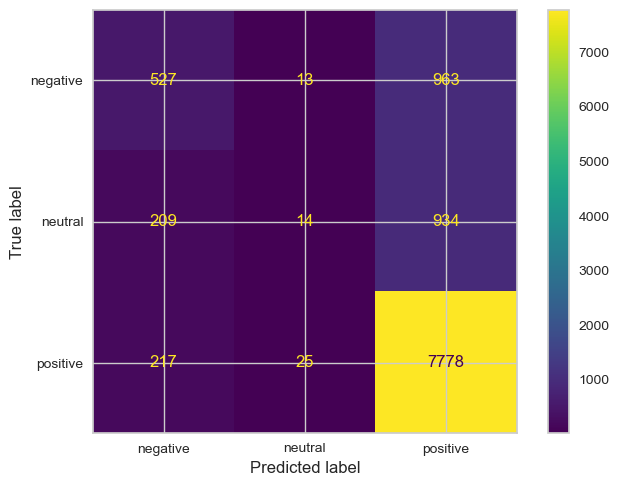

In [116]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
print(classification_report(y_test,y_pred))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

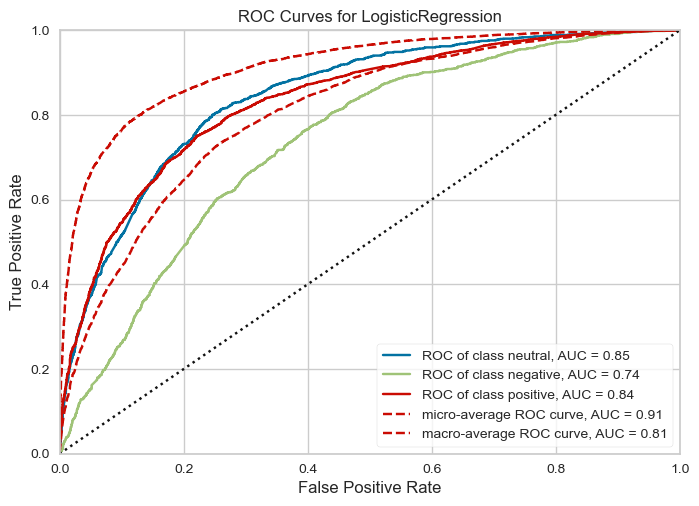

<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [117]:
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC, roc_auc
visualizer = ROCAUC(best_model, classes=y.unique())

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

## Naive Bayes

In [120]:
# Use GridSearchCV to find the best parameters for the models
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# Create a list of parameters of Naive Bayes for the GridSearchCV
# define models and parameters
model2 = MultinomialNB()
alpha = [0.1, 0.5, 1.0, 10.0]
fit_prior = [True, False]

grid2 = dict(alpha=alpha, fit_prior=fit_prior)
#param_grid = {
    #'n_estimators': [100,300, 500, 1000],
    #'learning_rate':[0.001,0.01,0.1, 1]
#}
# Create a list of models to test
clf_grid2 = GridSearchCV(estimator=model2, param_grid=grid2, n_jobs=-1,cv=5, scoring='accuracy', error_score=0)
search_clf2 = clf_grid2.fit(X_train, y_train)
best_clf2 = search_clf2.best_estimator_  
##Score
#cross_clf = cross_val_score(best_clf, X_test, y_test, scoring='accuracy', cv=5, n_jobs=-1)

In [121]:
print('Best params:', search_clf2.best_params_)

Best params: {'alpha': 0.1, 'fit_prior': True}


In [122]:
#create best model
best_model2 = MultinomialNB(alpha=0.1, fit_prior=True)
# Fit the best model to the training data
best_model2.fit(X_train, y_train)
y_pred2 = best_model2.predict(X_test)

In [123]:
# Get the accuracy score for the best model
accuracy_train2 = round(best_model2.score(X_train, y_train) * 100, 3)
accuracy_test2 = round(best_model2.score(X_test, y_test) * 100, 3)
print('Accuracy score for the best model on the training data: ', accuracy_train2)
print('Accuracy score for the best model on the test data: ', accuracy_test2)

Accuracy score for the best model on the training data:  76.647
Accuracy score for the best model on the test data:  77.238


c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.66      0.20      0.30      1503
     neutral       0.00      0.00      0.00      1157
    positive       0.78      0.99      0.87      8020

    accuracy                           0.77     10680
   macro avg       0.48      0.40      0.39     10680
weighted avg       0.68      0.77      0.70     10680



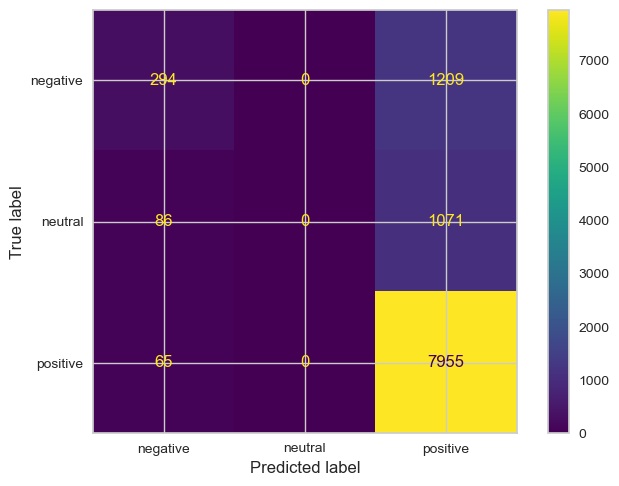

In [124]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
print(classification_report(y_test,y_pred2))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred2)